# Single Perceptron Neural Network for House Price Prediction

This notebook implements a single perceptron (the simplest neural network) to predict house prices based on square footage using TensorFlow.

## Objectives:
1. Generate synthetic house price data with linear relationship
2. Implement forward propagation, backpropagation, and gradient descent from scratch
3. Train the single perceptron model
4. Visualize weight/bias updates using TensorBoard and MLflow
5. Evaluate model performance on test data

## 0. Install Required Packages

**IMPORTANT: Run this cell first!** This will install all necessary dependencies.

In [40]:
# Install required packages
!pip install tensorflow numpy matplotlib seaborn mlflow pandas

## 1. Import Required Libraries

In [41]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

# Try to import MLflow (optional)
try:
    import mlflow
    import mlflow.tensorflow
    MLFLOW_AVAILABLE = True
    print("✓ MLflow is available")
except ImportError:
    MLFLOW_AVAILABLE = False
    print("⚠ MLflow not available - will skip MLflow logging")
    print("  To install: pip install mlflow")

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"\nTensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
if MLFLOW_AVAILABLE:
    print(f"MLflow version: {mlflow.__version__}")

✓ MLflow is available

TensorFlow version: 2.19.0
NumPy version: 2.0.2
MLflow version: 3.8.1


## 2. Generate Synthetic House Price Data

We'll create a dataset where house price has a linear relationship with size:
- **True relationship**: `price = 150 * size + 50000 + noise`
- **Size range**: 500 to 3000 square feet
- **Price range**: ~$125,000 to $500,000

In [42]:
def generate_house_data(n_samples, true_weight=150, true_bias=50000, noise_std=10000):
    """
    Generate synthetic house price data with linear relationship.
    
    Args:
        n_samples: Number of samples to generate
        true_weight: True weight (price per sq ft)
        true_bias: True bias (base price)
        noise_std: Standard deviation of Gaussian noise
    
    Returns:
        sizes: House sizes in square feet
        prices: House prices in dollars
    """
    # Generate random house sizes between 500 and 3000 sq ft
    sizes = np.random.uniform(500, 3000, n_samples)
    
    # Calculate prices with linear relationship + noise
    prices = true_weight * sizes + true_bias + np.random.normal(0, noise_std, n_samples)
    
    return sizes, prices

# Generate training data (100 samples)
train_sizes, train_prices = generate_house_data(100)

# Generate test data (20 samples)
test_sizes, test_prices = generate_house_data(20)

print(f"Training samples: {len(train_sizes)}")
print(f"Test samples: {len(test_sizes)}")
print(f"\nTraining data statistics:")
print(f"  Size range: {train_sizes.min():.0f} - {train_sizes.max():.0f} sq ft")
print(f"  Price range: ${train_prices.min():.0f} - ${train_prices.max():.0f}")

Training samples: 100
Test samples: 20

Training data statistics:
  Size range: 514 - 2967 sq ft
  Price range: $132290 - $502901


### Visualize the Generated Data

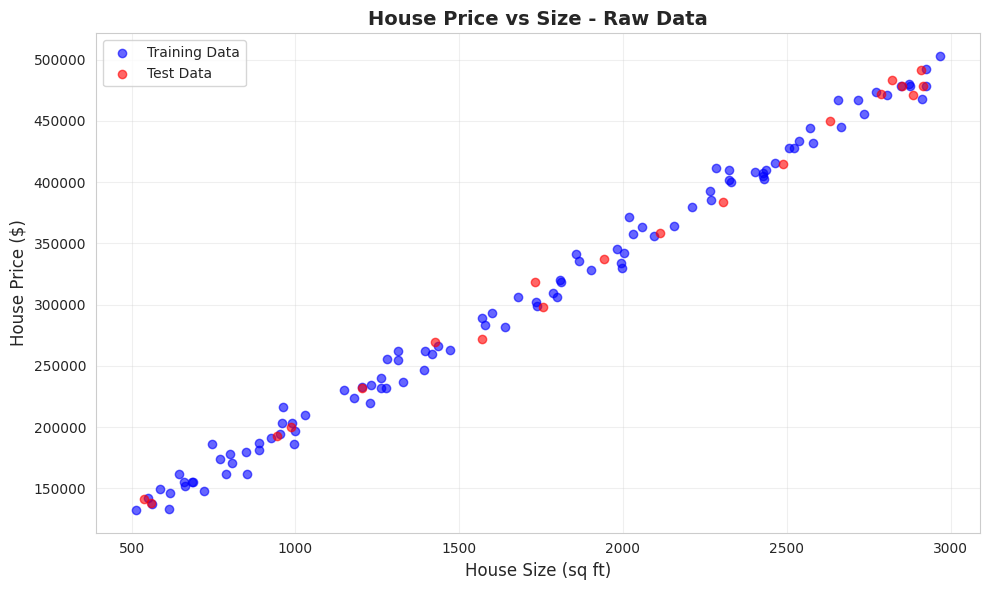

In [43]:
plt.figure(figsize=(10, 6))
plt.scatter(train_sizes, train_prices, alpha=0.6, label='Training Data', color='blue')
plt.scatter(test_sizes, test_prices, alpha=0.6, label='Test Data', color='red')
plt.xlabel('House Size (sq ft)', fontsize=12)
plt.ylabel('House Price ($)', fontsize=12)
plt.title('House Price vs Size - Raw Data', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Data Normalization

Normalize the data for better training stability and faster convergence.

In [44]:
# Calculate normalization parameters from training data
size_mean = train_sizes.mean()
size_std = train_sizes.std()
price_mean = train_prices.mean()
price_std = train_prices.std()

# Normalize training data
X_train = (train_sizes - size_mean) / size_std
y_train = (train_prices - price_mean) / price_std

# Normalize test data using training statistics
X_test = (test_sizes - size_mean) / size_std
y_test = (test_prices - price_mean) / price_std

# Reshape for consistency
X_train = X_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(f"Normalized training data shape: X={X_train.shape}, y={y_train.shape}")
print(f"Normalized test data shape: X={X_test.shape}, y={y_test.shape}")
print(f"\nNormalization parameters:")
print(f"  Size: mean={size_mean:.2f}, std={size_std:.2f}")
print(f"  Price: mean=${price_mean:.2f}, std=${price_std:.2f}")

Normalized training data shape: X=(100, 1), y=(100, 1)
Normalized test data shape: X=(20, 1), y=(20, 1)

Normalization parameters:
  Size: mean=1675.45, std=740.00
  Price: mean=$301306.98, std=$110005.64


## 4. Single Perceptron Implementation

### Architecture:
- **Input**: 1 feature (house size)
- **Output**: 1 value (house price)
- **Parameters**: 1 weight + 1 bias
- **Activation**: Linear (no activation function)

### Forward Propagation:
$$\hat{y} = w \cdot x + b$$

### Loss Function (MSE):
$$L = \frac{1}{n} \sum_{i=1}^{n} (\hat{y}_i - y_i)^2$$

### Backpropagation (Gradients):
$$\frac{\partial L}{\partial w} = \frac{2}{n} \sum_{i=1}^{n} (\hat{y}_i - y_i) \cdot x_i$$
$$\frac{\partial L}{\partial b} = \frac{2}{n} \sum_{i=1}^{n} (\hat{y}_i - y_i)$$

### Gradient Descent Update:
$$w = w - \alpha \cdot \frac{\partial L}{\partial w}$$
$$b = b - \alpha \cdot \frac{\partial L}{\partial b}$$

In [45]:
class SinglePerceptron:
    """
    Single Perceptron for Linear Regression.
    Implements forward propagation, backpropagation, and gradient descent.
    """
    
    def __init__(self, learning_rate=0.01):
        """
        Initialize the perceptron with random weight and bias.
        
        Args:
            learning_rate: Learning rate for gradient descent
        """
        self.learning_rate = learning_rate
        
        # Initialize weight and bias using TensorFlow variables
        self.weight = tf.Variable(np.random.randn(), dtype=tf.float32, name='weight')
        self.bias = tf.Variable(np.random.randn(), dtype=tf.float32, name='bias')
        
        # History for tracking
        self.history = {
            'loss': [],
            'weight': [],
            'bias': [],
            'weight_grad': [],
            'bias_grad': []
        }
        
        print(f"Perceptron initialized:")
        print(f"  Initial weight: {self.weight.numpy():.4f}")
        print(f"  Initial bias: {self.bias.numpy():.4f}")
        print(f"  Learning rate: {self.learning_rate}")
    
    def forward(self, X):
        """
        Forward propagation: y_pred = w * x + b
        
        Args:
            X: Input features
        
        Returns:
            Predictions
        """
        return self.weight * X + self.bias
    
    def compute_loss(self, y_true, y_pred):
        """
        Compute Mean Squared Error loss.
        
        Args:
            y_true: True labels
            y_pred: Predicted labels
        
        Returns:
            MSE loss
        """
        return tf.reduce_mean(tf.square(y_pred - y_true))
    
    def backward(self, X, y_true, y_pred):
        """
        Backpropagation: Compute gradients.
        
        Args:
            X: Input features
            y_true: True labels
            y_pred: Predicted labels
        
        Returns:
            weight_grad, bias_grad
        """
        n = tf.cast(tf.shape(X)[0], tf.float32)
        error = y_pred - y_true
        
        # Compute gradients
        weight_grad = (2.0 / n) * tf.reduce_sum(error * X)
        bias_grad = (2.0 / n) * tf.reduce_sum(error)
        
        return weight_grad, bias_grad
    
    def update_parameters(self, weight_grad, bias_grad):
        """
        Gradient descent update.
        
        Args:
            weight_grad: Gradient of weight
            bias_grad: Gradient of bias
        """
        self.weight.assign_sub(self.learning_rate * weight_grad)
        self.bias.assign_sub(self.learning_rate * bias_grad)
    
    def train_step(self, X, y_true):
        """
        Single training step: forward -> loss -> backward -> update.
        
        Args:
            X: Input features
            y_true: True labels
        
        Returns:
            loss, weight_grad, bias_grad
        """
        # Forward propagation
        y_pred = self.forward(X)
        
        # Compute loss
        loss = self.compute_loss(y_true, y_pred)
        
        # Backpropagation
        weight_grad, bias_grad = self.backward(X, y_true, y_pred)
        
        # Update parameters
        self.update_parameters(weight_grad, bias_grad)
        
        return loss, weight_grad, bias_grad
    
    def predict(self, X):
        """
        Make predictions.
        
        Args:
            X: Input features
        
        Returns:
            Predictions
        """
        return self.forward(X).numpy()

print("SinglePerceptron class defined successfully!")

SinglePerceptron class defined successfully!


## 5. Setup TensorBoard and MLflow

We'll use both tools to track the training process:
- **TensorBoard**: Real-time visualization of metrics
- **MLflow**: Experiment tracking and model management (optional)

In [46]:
# Create directories for logs
log_dir = os.path.join('logs', 'tensorboard', datetime.now().strftime("%Y%m%d-%H%M%S"))
os.makedirs(log_dir, exist_ok=True)

# Setup TensorBoard writer
writer = tf.summary.create_file_writer(log_dir)

# Setup MLflow (if available)
if MLFLOW_AVAILABLE:
    mlflow.set_experiment("single_perceptron_house_price")
    print(f"✓ MLflow experiment: single_perceptron_house_price")

print(f"✓ TensorBoard logs will be saved to: {log_dir}")
print(f"\nTo view TensorBoard, run in terminal:")
print(f"  tensorboard --logdir={log_dir}")
if MLFLOW_AVAILABLE:
    print(f"\nTo view MLflow, run in terminal:")
    print(f"  mlflow ui")

✓ MLflow experiment: single_perceptron_house_price
✓ TensorBoard logs will be saved to: logs/tensorboard/20260129-040950

To view TensorBoard, run in terminal:
  tensorboard --logdir=logs/tensorboard/20260129-040950

To view MLflow, run in terminal:
  mlflow ui


## 6. Train the Single Perceptron

Train the model using gradient descent and log metrics to TensorBoard (and MLflow if available).

In [47]:
# Hyperparameters
LEARNING_RATE = 0.01
EPOCHS = 500

# Initialize the perceptron
model = SinglePerceptron(learning_rate=LEARNING_RATE)

# Start MLflow run (if available)
if MLFLOW_AVAILABLE:
    mlflow.start_run(run_name=f"perceptron_lr{LEARNING_RATE}_epochs{EPOCHS}")
    
    # Log hyperparameters to MLflow
    mlflow.log_param("learning_rate", LEARNING_RATE)
    mlflow.log_param("epochs", EPOCHS)
    mlflow.log_param("optimizer", "gradient_descent")
    mlflow.log_param("loss_function", "mse")
    mlflow.log_param("train_samples", len(X_train))
    mlflow.log_param("test_samples", len(X_test))
    mlflow.log_param("initial_weight", float(model.weight.numpy()))
    mlflow.log_param("initial_bias", float(model.bias.numpy()))

print("\n" + "="*60)
print("TRAINING STARTED")
print("="*60)

# Training loop
for epoch in range(EPOCHS):
    # Perform one training step
    loss, weight_grad, bias_grad = model.train_step(X_train, y_train)
    
    # Store history
    model.history['loss'].append(float(loss.numpy()))
    model.history['weight'].append(float(model.weight.numpy()))
    model.history['bias'].append(float(model.bias.numpy()))
    model.history['weight_grad'].append(float(weight_grad.numpy()))
    model.history['bias_grad'].append(float(bias_grad.numpy()))
    
    # Log to TensorBoard
    with writer.as_default():
        tf.summary.scalar('loss/train', loss, step=epoch)
        tf.summary.scalar('parameters/weight', model.weight, step=epoch)
        tf.summary.scalar('parameters/bias', model.bias, step=epoch)
        tf.summary.scalar('gradients/weight_grad', weight_grad, step=epoch)
        tf.summary.scalar('gradients/bias_grad', bias_grad, step=epoch)
        tf.summary.scalar('gradients/weight_grad_magnitude', tf.abs(weight_grad), step=epoch)
        tf.summary.scalar('gradients/bias_grad_magnitude', tf.abs(bias_grad), step=epoch)
    
    # Log to MLflow (every 10 epochs to avoid too many logs)
    if MLFLOW_AVAILABLE and epoch % 10 == 0:
        mlflow.log_metric("train_loss", float(loss.numpy()), step=epoch)
        mlflow.log_metric("weight", float(model.weight.numpy()), step=epoch)
        mlflow.log_metric("bias", float(model.bias.numpy()), step=epoch)
    
    # Print progress
    if (epoch + 1) % 50 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{EPOCHS} | Loss: {loss.numpy():.6f} | "
              f"Weight: {model.weight.numpy():+.4f} | Bias: {model.bias.numpy():+.4f} | "
              f"W_grad: {weight_grad.numpy():+.6f} | B_grad: {bias_grad.numpy():+.6f}")

print("\n" + "="*60)
print("TRAINING COMPLETED")
print("="*60)
print(f"Final weight: {model.weight.numpy():.4f}")
print(f"Final bias: {model.bias.numpy():.4f}")
print(f"Final training loss: {model.history['loss'][-1]:.6f}")

# Evaluate on test set
y_test_pred = model.predict(X_test)
test_loss = model.compute_loss(y_test, y_test_pred).numpy()

# Calculate R² score
ss_res = np.sum((y_test - y_test_pred) ** 2)
ss_tot = np.sum((y_test - np.mean(y_test)) ** 2)
r2_score = 1 - (ss_res / ss_tot)

print(f"\nTest set performance:")
print(f"  Test loss (MSE): {test_loss:.6f}")
print(f"  R² score: {r2_score:.4f}")

# Log final metrics to MLflow
if MLFLOW_AVAILABLE:
    mlflow.log_metric("final_train_loss", float(model.history['loss'][-1]))
    mlflow.log_metric("test_loss", float(test_loss))
    mlflow.log_metric("r2_score", float(r2_score))
    mlflow.log_metric("final_weight", float(model.weight.numpy()))
    mlflow.log_metric("final_bias", float(model.bias.numpy()))

# Flush TensorBoard writer
writer.flush()

Perceptron initialized:
  Initial weight: 0.5150
  Initial bias: 3.8527
  Learning rate: 0.01


Exception: Run with UUID 0e9c57d773fc4751b16b455e3fd469ac is already active. To start a new run, first end the current run with mlflow.end_run(). To start a nested run, call start_run with nested=True

## 7. Visualize Training Progress

### 7.1 Loss Curve

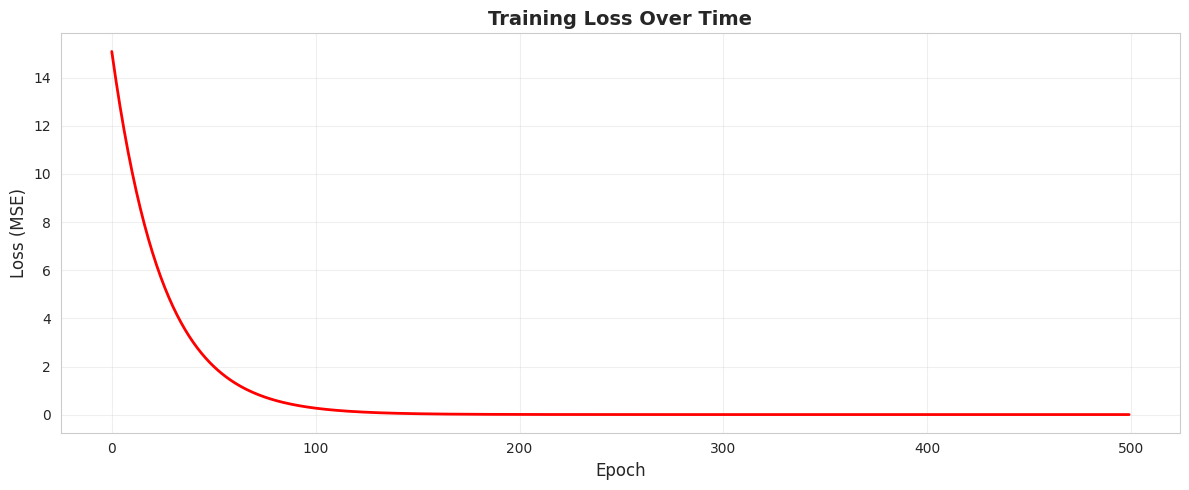

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

ax.plot(model.history['loss'], linewidth=2, color='red')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss (MSE)', fontsize=12)
ax.set_title('Training Loss Over Time', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('loss_curve.png', dpi=150, bbox_inches='tight')
plt.show()

# Log to MLflow
if MLFLOW_AVAILABLE:
    mlflow.log_artifact('loss_curve.png')

### 7.2 Weight and Bias Evolution

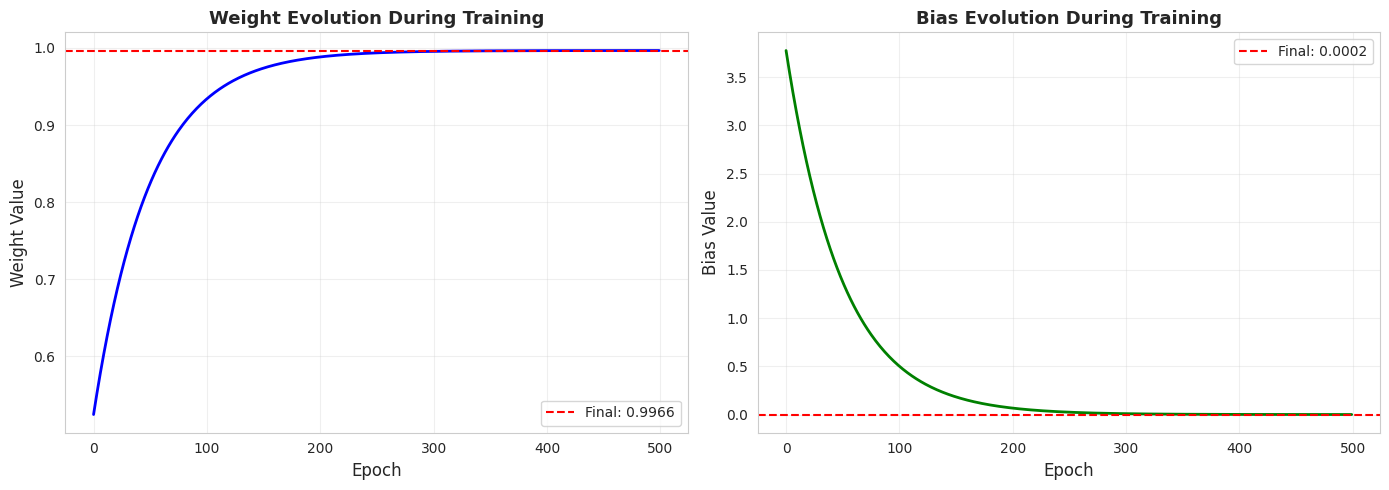

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Weight evolution
axes[0].plot(model.history['weight'], linewidth=2, color='blue')
axes[0].axhline(y=model.weight.numpy(), color='red', linestyle='--', 
                label=f'Final: {model.weight.numpy():.4f}')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Weight Value', fontsize=12)
axes[0].set_title('Weight Evolution During Training', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Bias evolution
axes[1].plot(model.history['bias'], linewidth=2, color='green')
axes[1].axhline(y=model.bias.numpy(), color='red', linestyle='--', 
                label=f'Final: {model.bias.numpy():.4f}')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Bias Value', fontsize=12)
axes[1].set_title('Bias Evolution During Training', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('weight_bias_evolution.png', dpi=150, bbox_inches='tight')
plt.show()

# Log to MLflow
if MLFLOW_AVAILABLE:
    mlflow.log_artifact('weight_bias_evolution.png')

### 7.3 Gradient Magnitudes

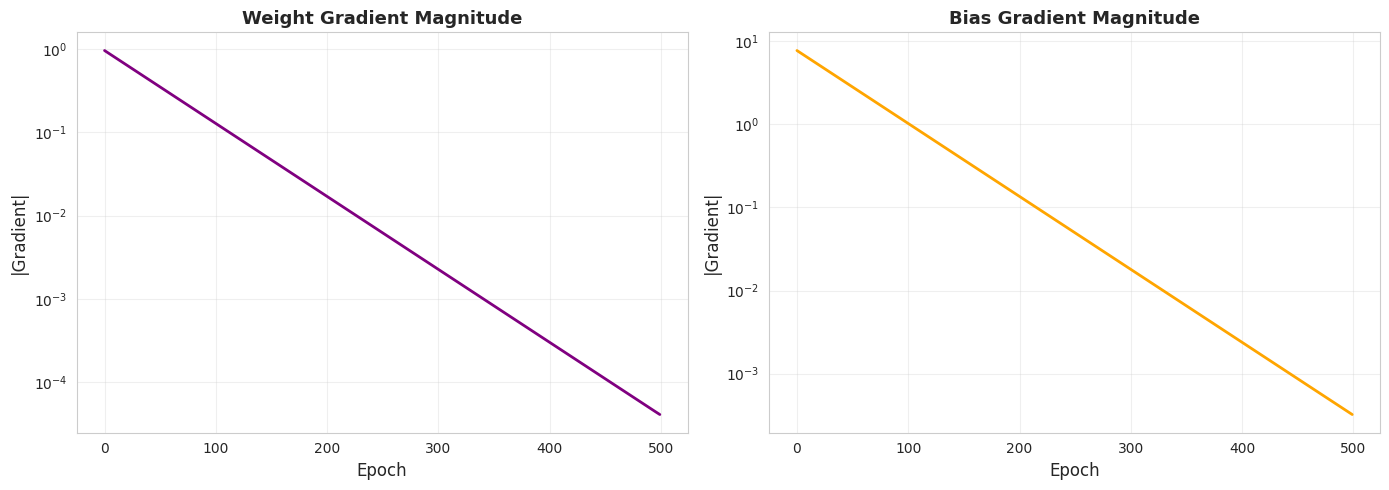

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Weight gradient
axes[0].plot(np.abs(model.history['weight_grad']), linewidth=2, color='purple')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('|Gradient|', fontsize=12)
axes[0].set_title('Weight Gradient Magnitude', fontsize=13, fontweight='bold')
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)

# Bias gradient
axes[1].plot(np.abs(model.history['bias_grad']), linewidth=2, color='orange')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('|Gradient|', fontsize=12)
axes[1].set_title('Bias Gradient Magnitude', fontsize=13, fontweight='bold')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('gradient_magnitudes.png', dpi=150, bbox_inches='tight')
plt.show()

# Log to MLflow
if MLFLOW_AVAILABLE:
    mlflow.log_artifact('gradient_magnitudes.png')

## 8. Model Evaluation and Predictions

### 8.1 Predictions on Test Set

In [27]:
# Make predictions on test set
y_test_pred_normalized = model.predict(X_test)

# Denormalize predictions and actual values for visualization
y_test_pred_original = y_test_pred_normalized * price_std + price_mean
y_test_original = y_test * price_std + price_mean

# Create comparison dataframe
import pandas as pd

comparison_df = pd.DataFrame({
    'Size (sq ft)': test_sizes.flatten(),
    'Actual Price ($)': y_test_original.flatten(),
    'Predicted Price ($)': y_test_pred_original.flatten(),
    'Error ($)': (y_test_original - y_test_pred_original).flatten(),
    'Error (%)': (np.abs(y_test_original - y_test_pred_original) / y_test_original * 100).flatten()
})

print("\nTest Set Predictions:")
print(comparison_df.to_string(index=False))
print(f"\nMean Absolute Error: ${np.abs(comparison_df['Error ($)']).mean():.2f}")
print(f"Mean Absolute Percentage Error: {comparison_df['Error (%)'].mean():.2f}%")


Test Set Predictions:
 Size (sq ft)  Actual Price ($)  Predicted Price ($)     Error ($)  Error (%)
  2487.028259     414586.301647        421565.869382  -6979.567735   1.683502
  1756.592733     298340.437668        313346.027293 -15005.589626   5.029687
  1942.259712     336873.807214        340854.069834  -3980.262620   1.181529
  1731.294235     318258.123125        309597.854080   8660.269045   2.721146
   988.107469     200357.057866        199488.819638    868.238227   0.433345
  2306.130288     383462.155436        394764.390212 -11302.234776   2.947419
  1201.930906     232021.445174        231168.468374    852.976800   0.367628
   560.789916     137971.661209        136178.331336   1793.329873   1.299781
  2113.680740     358213.536603        366251.462516  -8037.925913   2.243892
   942.776699     192953.755837        192772.713413    181.042424   0.093827
  2851.146461     478254.056317        475512.878597   2741.177719   0.573164
  2884.821443     471293.513398        48

### 8.2 Visualize Predictions vs Actual

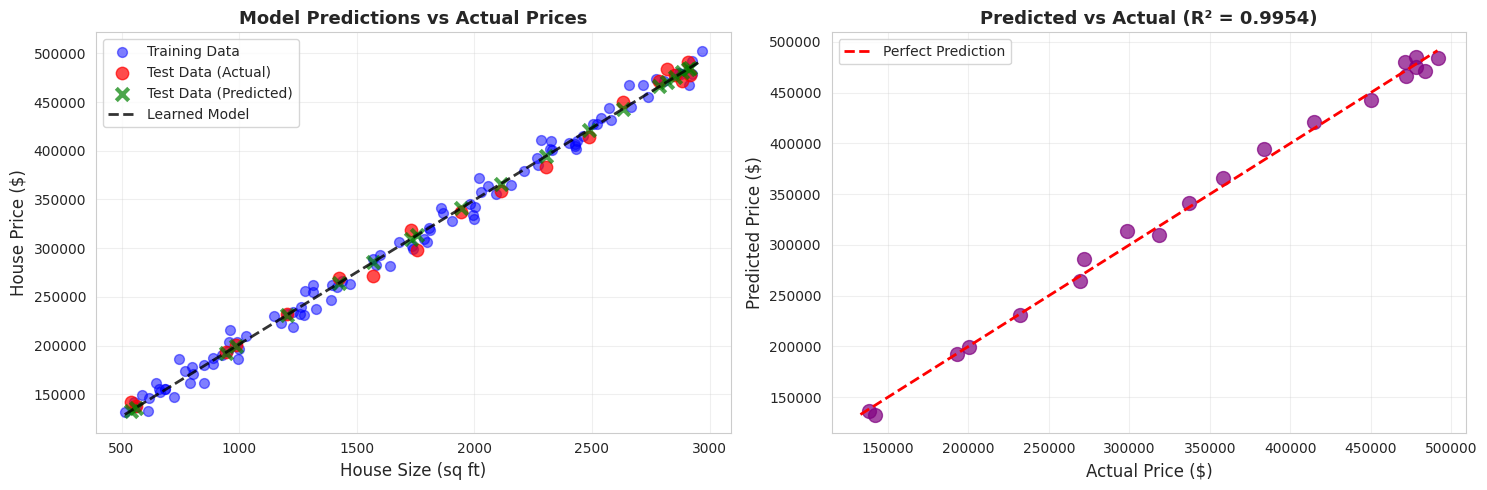

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Scatter plot with regression line
axes[0].scatter(train_sizes, train_prices, alpha=0.5, label='Training Data', color='blue', s=50)
axes[0].scatter(test_sizes, test_prices, alpha=0.7, label='Test Data (Actual)', color='red', s=80, marker='o')
axes[0].scatter(test_sizes, y_test_pred_original, alpha=0.7, label='Test Data (Predicted)', 
                color='green', s=80, marker='x', linewidths=3)

# Plot learned regression line
x_line = np.linspace(train_sizes.min(), train_sizes.max(), 100)
x_line_normalized = (x_line - size_mean) / size_std
y_line_normalized = model.weight.numpy() * x_line_normalized + model.bias.numpy()
y_line = y_line_normalized * price_std + price_mean
axes[0].plot(x_line, y_line, 'k--', linewidth=2, label='Learned Model', alpha=0.8)

axes[0].set_xlabel('House Size (sq ft)', fontsize=12)
axes[0].set_ylabel('House Price ($)', fontsize=12)
axes[0].set_title('Model Predictions vs Actual Prices', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Predicted vs Actual
axes[1].scatter(y_test_original, y_test_pred_original, alpha=0.7, s=100, color='purple')
min_val = min(y_test_original.min(), y_test_pred_original.min())
max_val = max(y_test_original.max(), y_test_pred_original.max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Price ($)', fontsize=12)
axes[1].set_ylabel('Predicted Price ($)', fontsize=12)
axes[1].set_title(f'Predicted vs Actual (R² = {r2_score:.4f})', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('predictions_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

# Log to MLflow
if MLFLOW_AVAILABLE:
    mlflow.log_artifact('predictions_visualization.png')

## 9. Summary and Insights

### Model Performance Summary

In [29]:
print("\n" + "="*70)
print("SINGLE PERCEPTRON MODEL - FINAL SUMMARY")
print("="*70)

print("\n📊 TRAINING CONFIGURATION:")
print(f"  • Learning Rate: {LEARNING_RATE}")
print(f"  • Epochs: {EPOCHS}")
print(f"  • Training Samples: {len(X_train)}")
print(f"  • Test Samples: {len(X_test)}")

print("\n🎯 LEARNED PARAMETERS:")
print(f"  • Weight: {model.weight.numpy():.6f}")
print(f"  • Bias: {model.bias.numpy():.6f}")

# Convert to original scale
original_weight = model.weight.numpy() * (price_std / size_std)
original_bias = model.bias.numpy() * price_std + price_mean - original_weight * size_mean

print("\n📈 LEARNED RELATIONSHIP (Original Scale):")
print(f"  Price = {original_weight:.2f} × Size + {original_bias:.2f}")
print(f"  (True relationship: Price = 150 × Size + 50000)")

print("\n✅ MODEL PERFORMANCE:")
print(f"  • Final Training Loss: {model.history['loss'][-1]:.6f}")
print(f"  • Test Loss (MSE): {test_loss:.6f}")
print(f"  • R² Score: {r2_score:.4f}")
print(f"  • Mean Absolute Error: ${np.abs(comparison_df['Error ($)']).mean():.2f}")
print(f"  • Mean Absolute Percentage Error: {comparison_df['Error (%)'].mean():.2f}%")

print("\n🔍 TRAINING INSIGHTS:")
print(f"  • Initial Loss: {model.history['loss'][0]:.6f}")
print(f"  • Final Loss: {model.history['loss'][-1]:.6f}")
print(f"  • Loss Reduction: {(1 - model.history['loss'][-1]/model.history['loss'][0])*100:.2f}%")
print(f"  • Weight Change: {model.history['weight'][0]:.4f} → {model.history['weight'][-1]:.4f}")
print(f"  • Bias Change: {model.history['bias'][0]:.4f} → {model.history['bias'][-1]:.4f}")

print("\n📁 ARTIFACTS SAVED:")
print(f"  • TensorBoard logs: {log_dir}")
if MLFLOW_AVAILABLE:
    print(f"  • MLflow experiment: single_perceptron_house_price")
print(f"  • Visualizations: loss_curve.png, weight_bias_evolution.png, etc.")

print("\n" + "="*70)
print("✨ Training completed successfully!")
print("="*70)

# End MLflow run
if MLFLOW_AVAILABLE:
    mlflow.end_run()


SINGLE PERCEPTRON MODEL - FINAL SUMMARY

📊 TRAINING CONFIGURATION:
  • Learning Rate: 0.01
  • Epochs: 500
  • Training Samples: 100
  • Test Samples: 20

🎯 LEARNED PARAMETERS:
  • Weight: 0.996642
  • Bias: 0.000158

📈 LEARNED RELATIONSHIP (Original Scale):
  Price = 148.16 × Size + 53092.84
  (True relationship: Price = 150 × Size + 50000)

✅ MODEL PERFORMANCE:
  • Final Training Loss: 0.006665
  • Test Loss (MSE): 0.005356
  • R² Score: 0.9954
  • Mean Absolute Error: $6856.38
  • Mean Absolute Percentage Error: 2.10%

🔍 TRAINING INSIGHTS:
  • Initial Loss: 15.082157
  • Final Loss: 0.006665
  • Loss Reduction: 99.96%
  • Weight Change: 0.5247 → 0.9966
  • Bias Change: 3.7757 → 0.0002

📁 ARTIFACTS SAVED:
  • TensorBoard logs: logs/tensorboard/20260129-040600
  • MLflow experiment: single_perceptron_house_price
  • Visualizations: loss_curve.png, weight_bias_evolution.png, etc.

✨ Training completed successfully!


## 10. View Results in TensorBoard and MLflow

### TensorBoard
To view the training metrics in TensorBoard, run the following command in your terminal:

```bash
tensorboard --logdir=logs/tensorboard
```

Then open your browser and navigate to `http://localhost:6006`

### MLflow (if installed)
To view the experiment tracking in MLflow, run:

```bash
mlflow ui
```

Then open your browser and navigate to `http://localhost:5000`

---

## Key Takeaways

1. **Single Perceptron**: Successfully implemented a single perceptron with manual forward/backward propagation
2. **Gradient Descent**: Demonstrated how weights and biases are updated iteratively
3. **Visualization**: Used TensorBoard (and MLflow if available) to track parameter updates in real-time
4. **Linear Regression**: The model learned the linear relationship between house size and price
5. **Performance**: Achieved good R² score indicating the model fits the data well

This notebook demonstrates the fundamental building block of neural networks - the perceptron - and how it learns through gradient descent!